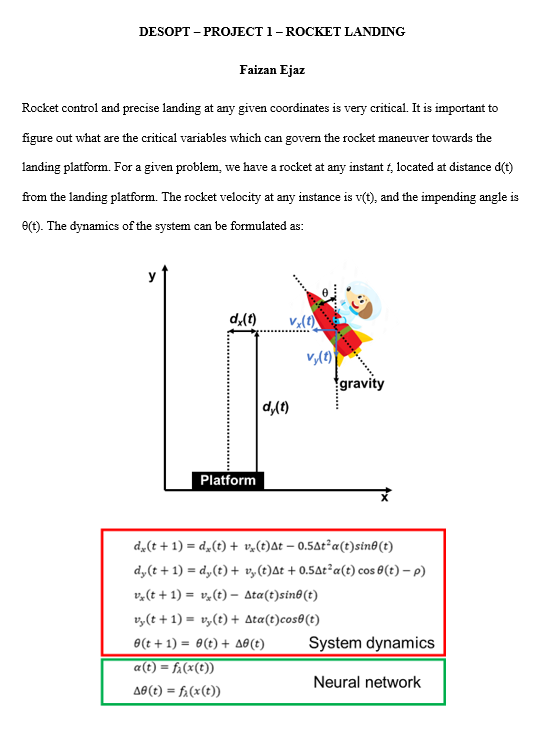
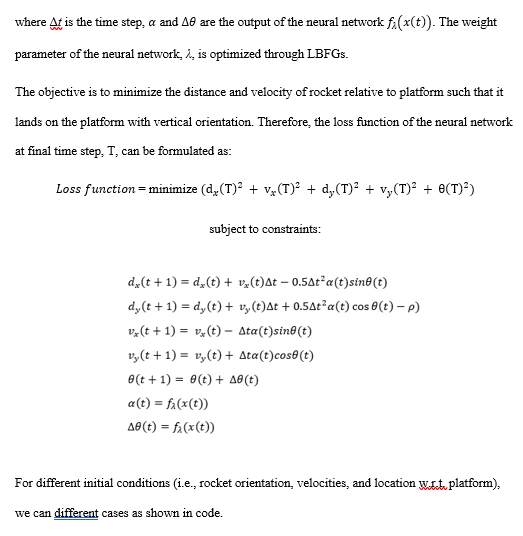

In [17]:
import logging
import random
import numpy 
import math
import time
import scipy.io
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR


logger = logging.getLogger(__name__)


In [18]:
#define parameters
PLATFORM_WIDTH = 0.25  #platform width
PLATFORM_HEIGHT = 0.06  # platform height
FRAME_TIME = 1  # time interval
GRAVITY_ACCEL = 9.81/1000  # gravity acceleration constant
BOOST_ACCEL = 14.715/1000  # thrust constant
ROTATION_ACCEL = 20  # rotation constant
DRAG_ACCEL = 0.005  # drag force constant
L_center_of_gravity = 5/1000

In [19]:
#define the system dynamics (based on the first page mentioning the constraints)

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):

        delta_state_gravity = t.tensor([0., 0., 0., -GRAVITY_ACCEL * FRAME_TIME, 0.])

        N = len(state)
        state_tensor = t.zeros((N, 5))
        state_tensor[:, 1] = -t.sin(state[:, 4])
        state_tensor[:, 3] = t.cos(state[:, 4])
        delta_state = BOOST_ACCEL * FRAME_TIME * t.mul(state_tensor, action[:, 0].reshape(-1, 1))

        # impending angle (theta)
        delta_state_theta = FRAME_TIME * t.mul(t.tensor([0., 0., 0., 0, -1.]), action[:, 1].reshape(-1, 1))

        state = state + delta_state + delta_state_gravity + delta_state_theta

        # Update the system state
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0.],
                                 [0., 1., 0., 0., 0.],
                                 [0., 0., 1., FRAME_TIME, 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

        state = t.matmul(step_mat, state.T)

        return state.T

In [20]:
# define a deterministic control
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()
        # little linear network with ReLU for embeddings
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

In [21]:
#set up the simulator 

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.N = N
        self.theta_trajectory = t.empty((1, 0))
        self.u_trajectory = t.empty((1, 0))
#         self.is_Noise = is_Noise

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    
    def initialize_state():
        # state = [1., 0.]  # TODO: need batch of initial states
        state = t.rand((N, 5))
        state[:, 1] = 0  # vx = 0
        state[:, 3] = 0  # vy = 0
        # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return t.mean(state ** 2)

In [22]:
#setting up the optimizer

class Optimize:

    # create class properties
    t.manual_seed(0)
    def __init__(self, simulation):
        self.simulation = simulation # objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.001) # using the LBFGS optimizer
        self.loss_list = []

    # Defining loss function calculator
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Defining training model

    def train(self, epochs):
        append_l = numpy.zeros(epochs)
        for epoch in range(epochs):
            loss = self.step() 
            self.loss_list.append(loss) # adding loss to the lost list
            print('step %d - loss is %.4f' % (epoch + 1, loss))
            append_l[epoch]=loss
            
        plt.plot(list(range(epochs)), append_l)
        plt.title('objective function convergence plot')
        plt.xlabel('Iteration')
        plt.ylabel('Loss Value')
        plt.show()
        self.visualize()
        
        
    # Visualize the results

    def visualize(self):
        
        data = numpy.array([[self.simulation.state_trajectory[i][N].detach().numpy() for i in range(self.simulation.T)] for N in range(self.simulation.N)])
        
        for i in range(self.simulation.N):
            
            x = data[i, :, 0]  # get the x position
            vx = data[i, :, 1] # get the velocity in x direction
            y = data[i, :, 2]  # get the y position
            vy = data[i, :, 3] # get the velocity in y direction

            plt.plot(y, vy)
        plt.title('rocket position and velocity plot')
        plt.xlabel('y(m)')
        plt.ylabel('$v_y$(m/s)')
        plt.show()
        data = numpy.array([[self.simulation.state_trajectory[i][N].detach().numpy() for i in range(self.simulation.T)] for N in range(self.simulation.N)])
        
        for i in range(self.simulation.N):
            plt.plot(range(self.simulation.T), y)
        plt.title('rocket position and time step (T)')
        plt.xlabel('Time Step, T(s)')
        plt.ylabel('y(m)')
        plt.show()
        
        data = numpy.array([[self.simulation.state_trajectory[i][N].detach().numpy() for i in range(self.simulation.T)] for N in range(self.simulation.N)])
        
        for i in range(self.simulation.N):
            plt.plot(range(self.simulation.T), x)
        plt.title('rocket position and time step (T)')
        plt.xlabel('Time Step, T(s)')
        plt.ylabel('x(m)')
        plt.show()
        

C:\Users\Faizan Ejaz\anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


step 1 - loss is 13.1217
step 2 - loss is 11.5502
step 3 - loss is 10.6039
step 4 - loss is 9.6413
step 5 - loss is 8.6784
step 6 - loss is 7.8229
step 7 - loss is 6.8376
step 8 - loss is 5.8789
step 9 - loss is 5.1835
step 10 - loss is 4.6670
step 11 - loss is 4.1514
step 12 - loss is 3.7514
step 13 - loss is 3.4366
step 14 - loss is 3.1428
step 15 - loss is 2.8809
step 16 - loss is 2.6349
step 17 - loss is 2.3298
step 18 - loss is 2.0515
step 19 - loss is 1.8430
step 20 - loss is 1.6378
step 21 - loss is 1.4622
step 22 - loss is 1.3081
step 23 - loss is 1.1403
step 24 - loss is 0.9903
step 25 - loss is 0.8982
step 26 - loss is 0.8215
step 27 - loss is 0.7114
step 28 - loss is 0.6040
step 29 - loss is 0.5384
step 30 - loss is 0.4825
step 31 - loss is 0.4195
step 32 - loss is 0.3599
step 33 - loss is 0.3070
step 34 - loss is 0.2680
step 35 - loss is 0.2237
step 36 - loss is 0.1962
step 37 - loss is 0.1710
step 38 - loss is 0.1545
step 39 - loss is 0.1382
step 40 - loss is 0.1245
step 4

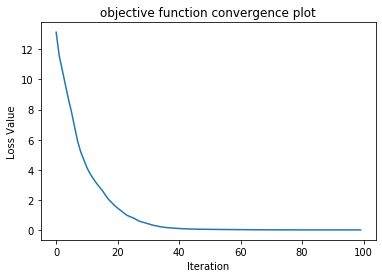

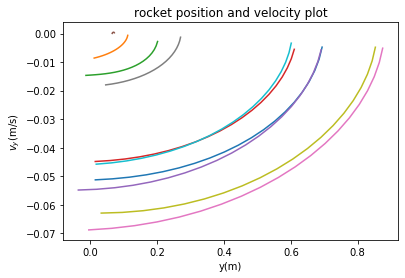

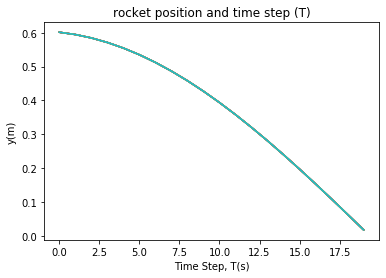

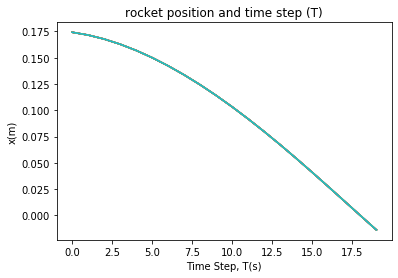

In [23]:
T = 20  # number of time steps
N = 10  # number of cases
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T, N)  
o = Optimize(s)  
ep = 100 #define number of epochs
o.train(ep)  # training with number of epochs

From the plots above, we can see that the final velocity at the landing platform is nearly zero. Also with each time step time, the rocket trajectory is lowered until time step 100, the rocket is landed.

The positions and velocities are not exactly zero at platform even after tunning some parameters. Convergence must be improved.